# Age discrepancy

Now we will try to correlate age discrepancy with some scores of the behavioral dataset. Our model to predict age uses only the structural MRI features.

In [72]:
import warnings
warnings.filterwarnings('ignore')
from utils import create_dataset_mri, cv_for_cde, create_dataset_eeg, cv
from cde.density_estimator import MixtureDensityNetwork
import numpy as np
import tensorflow as tf
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tensorflow.python.keras.activations import tanh
from sklearn.impute import SimpleImputer
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel

In [73]:
# Fix age threshold
threshold = 30

In [74]:
# Behavioral data
behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
# Create dataset MRI
target = 'Age'
data = create_dataset_mri(SCORE = target)

test = data.loc[data['DX_01'].isin(['Autism Spectrum Disorder', 'ADHD-Combined Type', 'ADHD-Inattentive Type', 'Specific Learning Disorder with Impairment in Reading'])]
healthy = data.loc[data['DX_01'].isin(['No Diagnosis Given'])]
train = data.loc[~data['DX_01'].isin(['Autism Spectrum Disorder', 'ADHD-Combined Type', 'ADHD-Inattentive Type', 'No Diagnosis Given', 'Specific Learning Disorder with Impairment in Reading'])]

test = test = test[test['Age']<threshold]
healthy = healthy[healthy['Age']<threshold]
train = train[train['Age']<threshold]


train.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)
healthy.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)
test.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)



Text(0.5, 1.0, 'Specific Learning Disorder with Impairment in Reading')

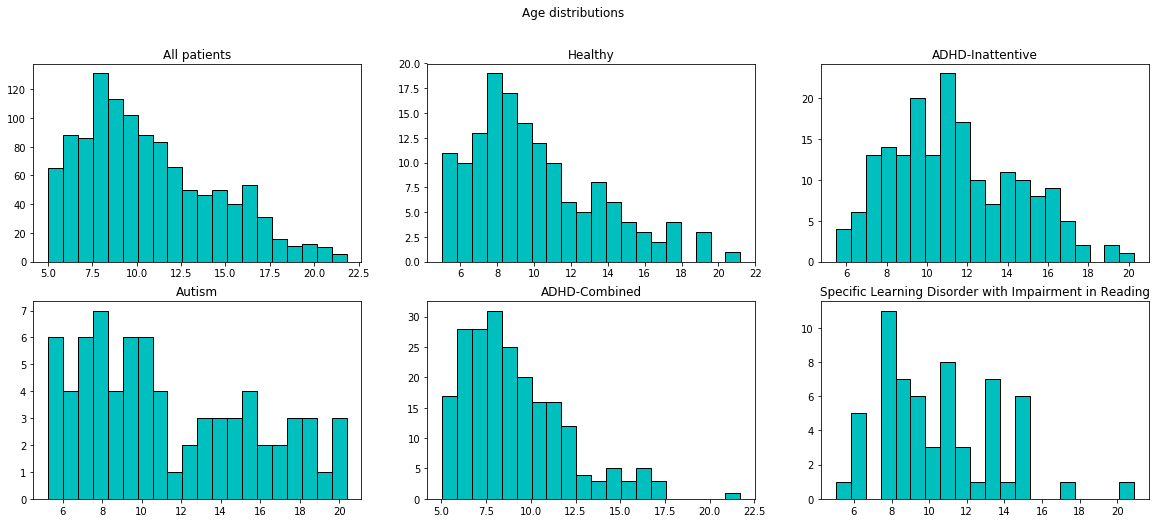

In [75]:
# Visualize distributions
autistics = data[data['DX_01']=='Autism Spectrum Disorder']
combined = data[data['DX_01']=='ADHD-Combined Type']
inattentive = data[data['DX_01']=='ADHD-Inattentive Type']
impaired = data[data['DX_01']=='Specific Learning Disorder with Impairment in Reading']
Healthy = data[data['DX_01']=='No Diagnosis Given']
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 8))
fig.suptitle('Age distributions')
ax1.hist(np.array(data[['Age']]), bins=20, color='c', edgecolor='k')
ax1.set_title('All patients')
ax2.hist(np.array(Healthy[['Age']]), bins=20, color='c', edgecolor='k')
ax2.set_title('Healthy')
ax3.hist(np.array(inattentive[['Age']]), bins=20, color='c', edgecolor='k')
ax3.set_title('ADHD-Inattentive')
ax4.hist(np.array(autistics[['Age']]), bins=20, color='c', edgecolor='k')
ax4.set_title('Autism')
ax5.hist(np.array(combined[['Age']]), bins=20, color='c', edgecolor='k')
ax5.set_title('ADHD-Combined')
ax6.hist(np.array(impaired[['Age']]), bins=20, color='c', edgecolor='k')
ax6.set_title('Specific Learning Disorder with Impairment in Reading')

In [86]:
# train
train = np.array(train)
ID_train_init = train[:,0]
X_train = train[:,2:]
y_train = train[:, 1]
y_train = y_train.reshape((-1,1))

# test
test = np.array(test)
ID_test_init = test[:,0]
X_test = test[:,2:]
y_test = test[:, 1]
y_test = y_test.reshape((-1,1))

# healthy
healthy = np.array(healthy)
y_healthy = healthy[:, 1]
X_healthy = np.concatenate((np.reshape(healthy[:,0],[-1,1]), healthy[:,2:]), axis = 1)
y_healthy = y_healthy.reshape((-1,1))


X_test_init = np.array(X_test, dtype=np.float64)
y_test_init = np.array(y_test, dtype=np.float64)
X_train_init = np.array(X_train, dtype=np.float64)
y_train_init  = np.array(y_train, dtype=np.float64)

# split the healthy
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_healthy, y_healthy, test_size=0.3, random_state=8)
y_train_h = y_train_h.reshape((-1,1))
y_test_h = y_test_h.reshape((-1,1))
ID_train_h = X_train_h[:,0]
X_train_h = X_train_h[:,1:]
ID_test_h = X_test_h[:,0]
X_test_h = X_test_h[:,1:]
y_train_h = np.array(y_train_h, dtype=np.float64)
X_train_h = np.array(X_train_h, dtype=np.float64)
y_test_h = np.array(y_test_h, dtype=np.float64)
X_test_h = np.array(X_test_h, dtype=np.float64)
# Now add again
ID_test = np.concatenate((ID_test_init, ID_test_h))
y_test = np.concatenate((y_test_init, y_test_h))
X_test = np.concatenate((X_test_init, X_test_h))

ID_train = ID_train_h
y_train = y_train_h
X_train = X_train_h

In [87]:
y_train.shape

(103, 1)

In [116]:
# Set model parameters
ndim_x=X_train.shape[1]
ndim_y=y_train.shape[1]
# We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
n = X_train.shape[0]
d = X_train.shape[1]+y_train.shape[1]
h = n**(-1/(d+1))
# Define the model
model = MixtureDensityNetwork('MDNe', ndim_x, ndim_y, n_centers=10, hidden_sizes=(16, 16), hidden_nonlinearity=tf.nn.tanh,
               n_training_epochs=1000, x_noise_std=h, y_noise_std=h, adaptive_noise_fn=None, entropy_reg_coef=0.0,
               weight_decay=0.0, weight_normalization=True, data_normalization=True, dropout=0.0, l2_reg=0.0, l1_reg=0.0,
               random_seed=42)
# Fit
model.fit(X_train, y_train)
# Predict
y_pred = model.mean_(X_test)
y_pred = y_pred.reshape((-1,1))
y_pred.shape
print('Test MSE: {}'.format(mean_squared_error(y_pred, y_test)))

1000/1000 [100%] ██████████████████████████████ Elapsed: 12s | loss: 154.032
mean log-loss train: 1.4955
Test MSE: 6.371784849570758


In [104]:
# Random Forest
pipe1 = Pipeline([ ('scaling', StandardScaler()),
  ('regression', RandomForestRegressor(n_estimators=200, n_jobs=4))
])

# SVM
pipe2 = Pipeline([ ('scaling', StandardScaler()),
  ('feat_select', SelectFromModel(ExtraTreesRegressor(100))),
  ('regression', SVR(kernel='rbf', C=1, epsilon=0.1))
])

# Set model parameters
ndim_x=X_train.shape[1]
ndim_y=y_train.shape[1]
# We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
n = X_train.shape[0]
d = X_train.shape[1]+y_train.shape[1]
h = n**(-1/(d+1))
# Define the model
model = pipe1
# Fit
model.fit(X_train, y_train)
# Predict
y_pred = model.predict(X_test)
y_pred = y_pred.reshape((-1,1))
y_pred.shape
print('Test MSE: {}'.format(mean_squared_error(y_pred, y_test)))
res_cv = cv(model=pipe2, data=X_train, labels=y_train.reshape([y_train.shape[0]]), n_splits=5)

Test MSE: 6.728529061200111


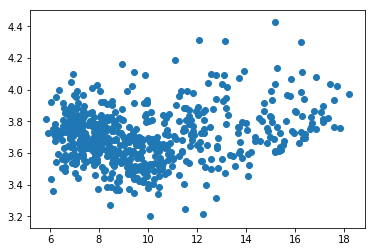

In [120]:
plt.scatter( model.mean_(X_test), model.std_(X_test))
plt.show()

In [64]:
np.mean(res_cv)

6.128502342314218

In [126]:
# Define discrepancy
std = model.std_(X_test)
discrepancy = np.divide((y_test-y_pred), 1+std)
#discrepancy = y_test-y_pred

In [127]:
# Get dataframe for test observations with behavioral data + discrepancy
data = {'discrepancy':discrepancy[:,0]}
discrepancy_df = pd.DataFrame(data)
ID_df = pd.DataFrame({'EID':ID_test})
discrepancy_merged = pd.concat([ID_df, discrepancy_df], axis=1)
dataframe = pd.merge(discrepancy_merged, behavioral, how='inner', on='EID')
dataframe = dataframe.drop(['Anonymized.ID', 'Study.Site'], axis = 1)

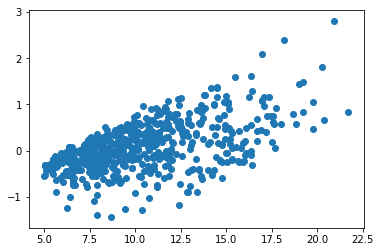

In [128]:
plt.scatter(dataframe['Age'], discrepancy)

In [94]:
# Get the correlations
correlations = dataframe[dataframe.columns[1:]].corr()['discrepancy'][:]
# Inspect correlations
correlations[correlations > 0.3]  

discrepancy                      1.000000
Age                              0.491079
DX_04_Presum                     0.391726
DX_05_PRem                       0.443122
FGC_Curl_Up                      0.301685
KBIT_NV_Raw                      0.361923
KBIT_V_Raw                       0.450231
STAI_SA_T                        0.556734
TRF_Pre_Anxious.Depressed_Raw    0.306275
TRF_Pre_Somatic_Raw              0.352011
VL_Comm1_Raw                     0.963907
VL_Comm2_Raw                     0.695679
VL_DLS1_Raw                      0.817481
VL_DLS2_Raw                      0.862659
VL_DLS3_Raw                      0.778073
VL_DLS_Scale                     0.999225
VL_Social1_Raw                   0.871374
VL_Social2_Raw                   0.992609
VL_Social3_Raw                   0.969096
VL_Social_Scale                  0.969951
WAIS_DS_B_R                      0.392416
WASI_Matrix_Raw                  0.301415
WASI_Vocab_Raw                   0.356655
WASI_BD_Raw                      0

In [95]:
# Frequencies of major disturb in behavioral dataset
dataframe['DX_01'].value_counts()

ADHD-Combined Type                                       217
ADHD-Inattentive Type                                    188
Autism Spectrum Disorder                                  73
Specific Learning Disorder with Impairment in Reading     61
No Diagnosis Given                                        45
Name: DX_01, dtype: int64

In [134]:
df = dataframe
autism = df[df['DX_01'] == 'Autism Spectrum Disorder']['discrepancy']
healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
res1 = ttest_ind(np.array(autism), np.array(healthy), equal_var=False)

In [135]:
res1

Ttest_indResult(statistic=3.3056509444865187, pvalue=0.0012745175843513208)

In [136]:
sani_adhd = df[df['DX_01'].isin(['No Diagnosis Given', 'ADHD-Inattentive Type'])]
sani_aut = df[df['DX_01'].isin(['No Diagnosis Given', 'Autism Spectrum Disorder'])]
sani_adhd.shape

(233, 446)

In [137]:
aut = df['DX_01'] == 'Autism Spectrum Disorder'
sum(aut)

73

             sum_sq     df          F        PR(>F)
DX_01      1.417262    1.0   6.740837  1.003005e-02
Age       12.035313    1.0  57.242825  9.197912e-13
Residual  48.357539  230.0        NaN           NaN


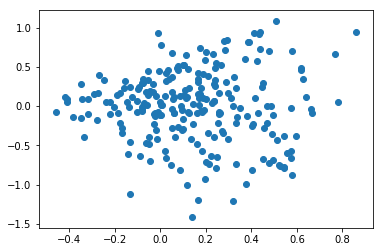

In [138]:
model = ols('discrepancy ~ Age + DX_01', data=sani_adhd).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)

res = model.resid
fitted = model.fittedvalues

plt.scatter(fitted, res)
plt.show()

             sum_sq     df          F        PR(>F)
DX_01      0.346909    1.0   1.914332  1.694742e-01
Age        6.987196    1.0  38.557069  1.133939e-08
Residual  18.665350  103.0        NaN           NaN


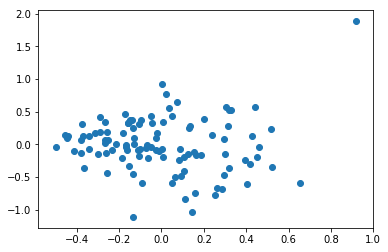

In [139]:
sani_learn = df[df['DX_01'].isin(['No Diagnosis Given', 'Specific Learning Disorder with Impairment in Reading'])]
model = ols('discrepancy ~ Age + DX_01', data=sani_learn).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)

res = model.resid
fitted = model.fittedvalues

plt.scatter(fitted, res)
plt.show()

             sum_sq     df          F        PR(>F)
DX_01      0.765243    1.0   4.508346  3.467820e-02
Age       15.903605    1.0  93.694417  4.096673e-19
Residual  43.962425  259.0        NaN           NaN


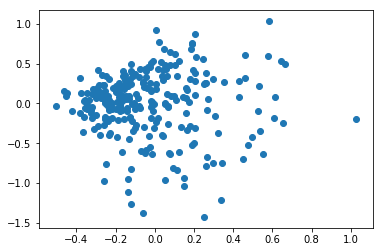

In [140]:
sani_learn = df[df['DX_01'].isin(['No Diagnosis Given', 'ADHD-Combined Type'])]
model = ols('discrepancy ~ Age + DX_01', data=sani_learn).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)

res = model.resid
fitted = model.fittedvalues

plt.scatter(fitted, res)
plt.show()

             sum_sq     df          F        PR(>F)
DX_01      1.041667    1.0   4.886244  2.905082e-02
Age       11.729385    1.0  55.020111  2.210806e-11
Residual  24.516113  115.0        NaN           NaN


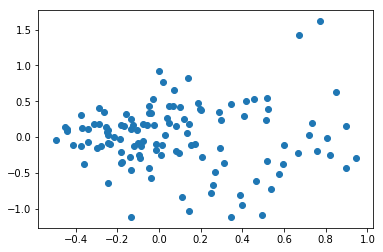

In [141]:
model = ols('discrepancy ~ Age + DX_01', data=sani_aut).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)

res = model.resid
fitted = model.fittedvalues

plt.scatter(fitted, res)
plt.show()

In [43]:
corrected = multipletests(pvals = np.array([0.007411, 0.18, 0.4, 0.143374]), alpha=0.05, method = 'fdr_bh')
corrected

(array([ True, False, False, False]),
 array([0.029644, 0.24    , 0.4     , 0.24    ]),
 0.012741455098566168,
 0.0125)

## Consider the most frequent situations: ADHD Inattentive, ADHD Combined, Autism, Healthy. Specific impairment in Reading

In [11]:
df = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type', 'ADHD-Inattentive Type','No Diagnosis Given', 'Autism Spectrum Disorder', 'Specific Learning Disorder with Impairment in Reading'])]
df = df[df['Age']<threshold]

# Visualization

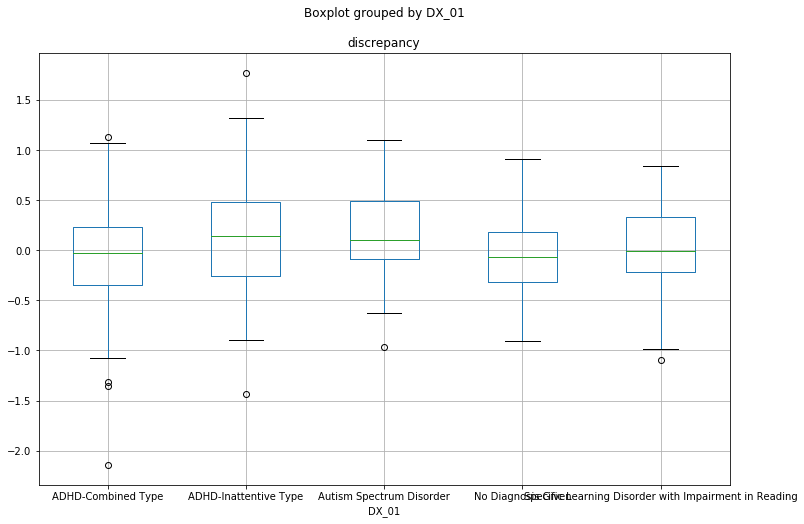

In [12]:
#Create a boxplot
df.boxplot('discrepancy', by='DX_01', figsize=(12, 8))

We got a significant F-test and significant pval for autism.

## Evaluate these quantities as an average over differen splits

In [13]:
def t_test(repetitions, multiple_testing_correction = 'fdr_bh', exclude_old = True, threshold = threshold):
    # Behavioral data
    behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
    # Create dataset MRI
    target = 'Age'
    data = create_dataset_mri(SCORE = target)

    test = data.loc[data['DX_01'].isin(['Autism Spectrum Disorder', 'ADHD-Combined Type', 'ADHD-Inattentive Type', 'Specific Learning Disorder with Impairment in Reading'])]
    healthy = data.loc[data['DX_01'].isin(['No Diagnosis Given'])]
    train = data.loc[~data['DX_01'].isin(['Autism Spectrum Disorder', 'ADHD-Combined Type', 'ADHD-Inattentive Type', 'No Diagnosis Given', 'Specific Learning Disorder with Impairment in Reading'])]
    
    if exclude_old == True:
        # Remove patients aged > threshold
        test = test = test[test['Age']<threshold]
        healthy = healthy[healthy['Age']<threshold]
        train = train[train['Age']<threshold]
    
    
    train.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)
    healthy.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)
    test.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)

    
    # train
    train = np.array(train)
    ID_train_init = train[:,0]
    X_train = train[:,2:]
    y_train = train[:, 1]
    y_train = y_train.reshape((-1,1))

    # test
    test = np.array(test)
    ID_test_init = test[:,0]
    X_test = test[:,2:]
    y_test = test[:, 1]
    y_test = y_test.reshape((-1,1))

    # healthy
    healthy = np.array(healthy)
    y_healthy = healthy[:, 1]
    X_healthy = np.concatenate((np.reshape(healthy[:,0],[-1,1]), healthy[:,2:]), axis = 1)
    y_healthy = y_healthy.reshape((-1,1))

    
    X_test_init = np.array(X_test, dtype=np.float64)
    y_test_init = np.array(y_test, dtype=np.float64)
    X_train_init = np.array(X_train, dtype=np.float64)
    y_train_init  = np.array(y_train, dtype=np.float64)
    
    # things I want to compute
    t_adhd = []
    t_adhd_combined = []
    t_autism = [] 
    t_impaired = []
    
    for i in range(repetitions):
        # split the healthy
        X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_healthy, y_healthy, test_size=0.5, random_state=i)
        y_train_h = y_train_h.reshape((-1,1))
        y_test_h = y_test_h.reshape((-1,1))
        ID_train_h = X_train_h[:,0]
        X_train_h = X_train_h[:,1:]
        ID_test_h = X_test_h[:,0]
        X_test_h = X_test_h[:,1:]
        y_train_h = np.array(y_train_h, dtype=np.float64)
        X_train_h = np.array(X_train_h, dtype=np.float64)
        y_test_h = np.array(y_test_h, dtype=np.float64)
        X_test_h = np.array(X_test_h, dtype=np.float64)
        # Now add again
        ID_test = np.concatenate((ID_test_init, ID_test_h))
        y_test = np.concatenate((y_test_init, y_test_h))
        X_test = np.concatenate((X_test_init, X_test_h))

        ID_train = np.concatenate((ID_train_init, ID_train_h))
        y_train = np.concatenate((y_train_init, y_train_h))
        X_train = np.concatenate((X_train_init, X_train_h))
    
        # Set model parameters
        ndim_x=X_train.shape[1]
        ndim_y=y_train.shape[1]
        # We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
        n = X_train.shape[0]
        d = X_train.shape[1]+y_train.shape[1]
        h = n**(-1/(d+1))
        model = MixtureDensityNetwork('{}'.format(i), ndim_x, ndim_y, n_centers=10, hidden_sizes=(16, 16), hidden_nonlinearity=tf.nn.tanh,
               n_training_epochs=1000, x_noise_std=h, y_noise_std=h, adaptive_noise_fn=None, entropy_reg_coef=0.0,
               weight_decay=0.0, weight_normalization=True, data_normalization=True, dropout=0.0, l2_reg=0.0, l1_reg=0.0,
               random_seed=42)
        
        # Fit
        model.fit(X_train, y_train)
        # Predict
        y_pred = model.mean_(X_test)
        y_pred = y_pred.reshape((-1,1))
        # Define discrepancy
        std = model.std_(X_test)
        discrepancy = np.divide((y_test-y_pred), 1+std)
        # Get dataframe for test observations with behavioral data + discrepancy
        data = {'discrepancy':discrepancy[:,0]}
        discrepancy_df = pd.DataFrame(data)
        ID_df = pd.DataFrame({'EID':ID_test})
        discrepancy_merged = pd.concat([ID_df, discrepancy_df], axis=1)
        df = pd.merge(discrepancy_merged, behavioral, how='inner', on='EID')
        
        # t-test for autism vs healthy
        autism = df[df['DX_01'] == 'Autism Spectrum Disorder']['discrepancy']
        healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res1 = ttest_ind(np.array(autism), np.array(healthy), equal_var=False)
        
        
        # t-test for inattentive vs healthy
        adhd = df[df['DX_01'] == 'ADHD-Inattentive Type']['discrepancy']
        healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res2 = ttest_ind(np.array(adhd), np.array(healthy), equal_var=False)
        
        
        # t-test for combined vs healthy
        combined = df[df['DX_01'] == 'ADHD-Combined Type']['discrepancy']
        healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res3 = ttest_ind(np.array(combined), np.array(healthy), equal_var=False)

        # t-test for impaired vs healthy
        impaired = df[df['DX_01'] == 'Specific Learning Disorder with Impairment in Reading']['discrepancy']
        healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res4 = ttest_ind(np.array(impaired), np.array(healthy), equal_var=False)
        
        # Correct p-values for multiple-testing
        p_vals = [res1[1], res2[1], res3[1], res4[1]]
        corrected = multipletests(pvals = p_vals, alpha=0.05, method = multiple_testing_correction)
        t_autism.append(corrected[1][0])
        t_adhd.append(corrected[1][1])
        t_adhd_combined.append(corrected[1][2])
        t_impaired.append(corrected[1][3])

        
    print('Mean t-test p-val (inattentive vs healthy): {} \n Mean t-test p-val (combined vs healthy): {} \n Mean t-test p-val (autism vs healthy): {}, \n Mean t-test p-val (impaired vs healthy): {}'.format(np.mean(t_adhd), np.mean(t_adhd_combined), np.mean(t_autism), np.mean(t_impaired)))

In [14]:
t_test(10)

1000/1000 [100%] ██████████████████████████████ Elapsed: 23s | loss: 637.021
mean log-loss train: 1.4219
1000/1000 [100%] ██████████████████████████████ Elapsed: 19s | loss: 638.077
mean log-loss train: 1.4243
1000/1000 [100%] ██████████████████████████████ Elapsed: 15s | loss: 641.496
mean log-loss train: 1.4319
1000/1000 [100%] ██████████████████████████████ Elapsed: 13s | loss: 630.812
mean log-loss train: 1.4081
1000/1000 [100%] ██████████████████████████████ Elapsed: 20s | loss: 658.314
mean log-loss train: 1.4694
1000/1000 [100%] ██████████████████████████████ Elapsed: 17s | loss: 677.927
mean log-loss train: 1.5132
1000/1000 [100%] ██████████████████████████████ Elapsed: 14s | loss: 675.998
mean log-loss train: 1.5089
1000/1000 [100%] ██████████████████████████████ Elapsed: 14s | loss: 635.267
mean log-loss train: 1.4180
1000/1000 [100%] ██████████████████████████████ Elapsed: 15s | loss: 654.783
mean log-loss train: 1.4616
1000/1000 [100%] ██████████████████████████████ Elapsed

Using the Benjamini-Hochberg correction.